<a href="https://colab.research.google.com/github/ritamgh/DLT-lab/blob/main/Week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt


In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape((-1, 28 * 28))
x_test = x_test.reshape((-1, 28 * 28))



In [ ]:
latent_dim = 2  # for visualization (you can use 16, 32, etc.)
input_dim = 784


In [ ]:
inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(256, activation="relu")(inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(h)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    200,960 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,988 (789.02 KB)

 Trainable params: 201,988 (789.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
outputs = layers.Dense(input_dim, activation="sigmoid")(x)
decoder = Model(latent_inputs, outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def compute_loss(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(data, reconstruction)
        ) * input_dim
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        total_loss = reconstruction_loss + kl_loss
        return total_loss, reconstruction_loss, kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            total_loss, reconstruction_loss, kl_loss = self.compute_loss(data)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        total_loss, reconstruction_loss, kl_loss = self.compute_loss(data)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

history = vae.fit(
    x_train,
    x_train,
    epochs=30,
    batch_size=256,
    validation_data=(x_test, x_test)
)


Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - kl_loss: 3.0559 - loss: 168.2960 - reconstruction_loss: 165.2401 - val_kl_loss: 3.3604 - val_loss: 171.0441 - val_reconstruction_loss: 167.6838
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 3.0838 - loss: 164.8361 - reconstruction_loss: 161.7523 - val_kl_loss: 3.2173 - val_loss: 164.6626 - val_reconstruction_loss: 161.4453
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - kl_loss: 3.1021 - loss: 163.0207 - reconstruction_loss: 159.9186 - val_kl_loss: 3.4868 - val_loss: 162.2396 - val_reconstruction_loss: 158.7528
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - kl_loss: 3.1481 - loss: 161.4291 - reconstruction_loss: 158.2810 - val_kl_loss: 3.2363 - val_loss: 159.8019 - val_reconstruction_loss: 156.5656
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - kl_loss: 3.1965 - loss: 160.0827 - reconstruction_loss: 156.8862 - val_kl_loss: 3.3437 - val_loss: 157.4565 - val_reconstruction_loss: 154.1128
Epoc

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


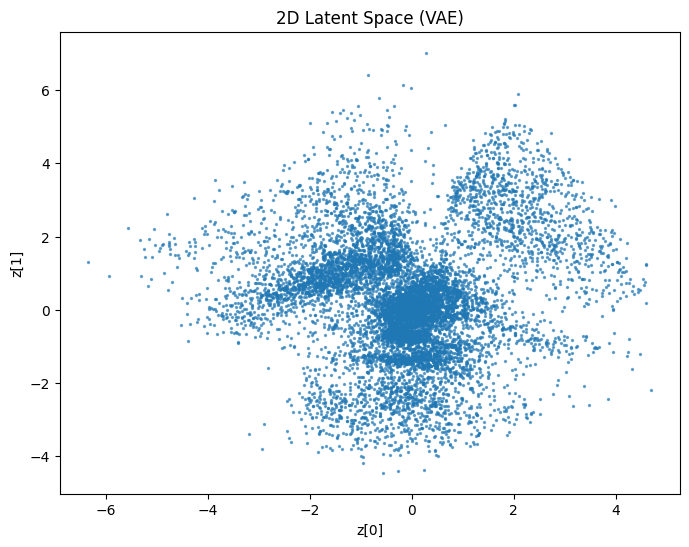

In [ ]:
z_mean, _, _ = encoder.predict(x_test)
plt.figure(figsize=(8,6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], s=2, alpha=0.6)
plt.title("2D Latent Space (VAE)")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━

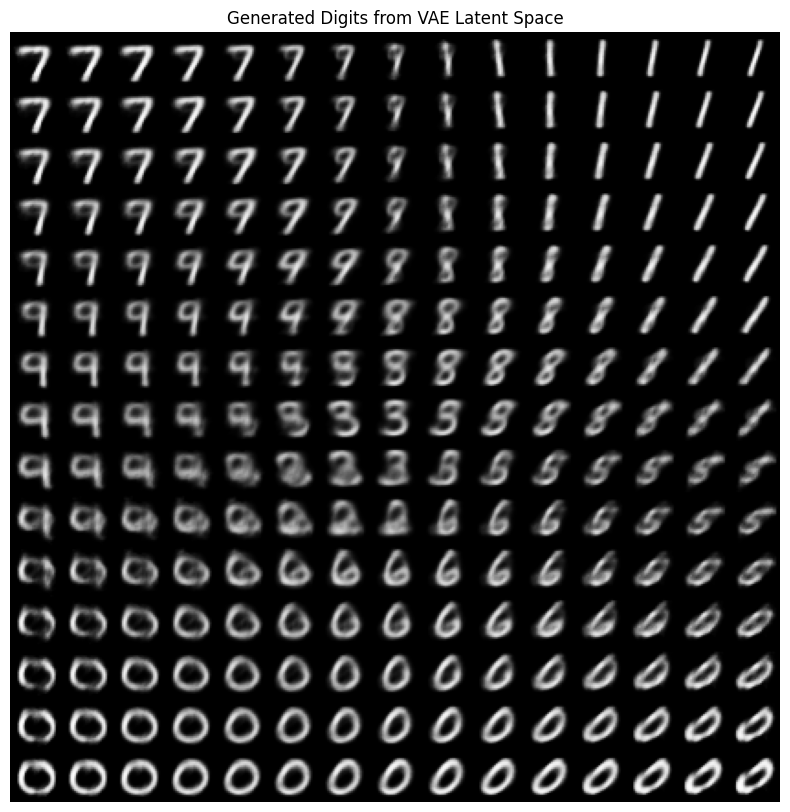

In [ ]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Grid of latent variable values
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.title("Generated Digits from VAE Latent Space")
plt.axis('off')
plt.show()


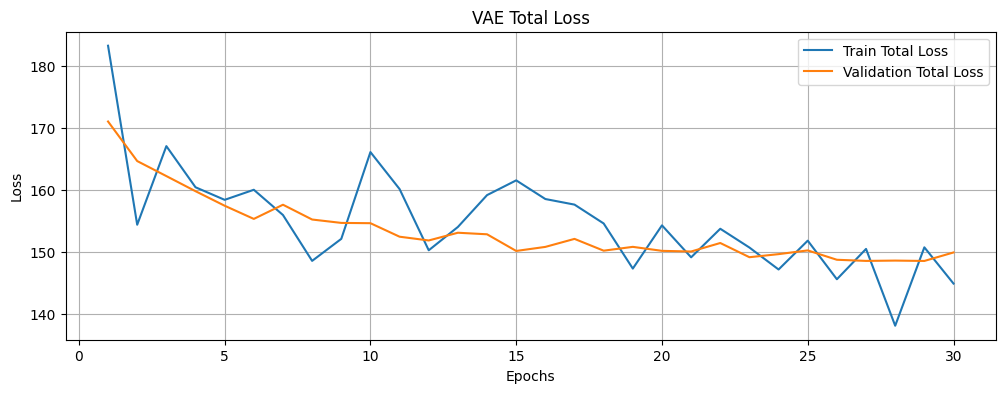

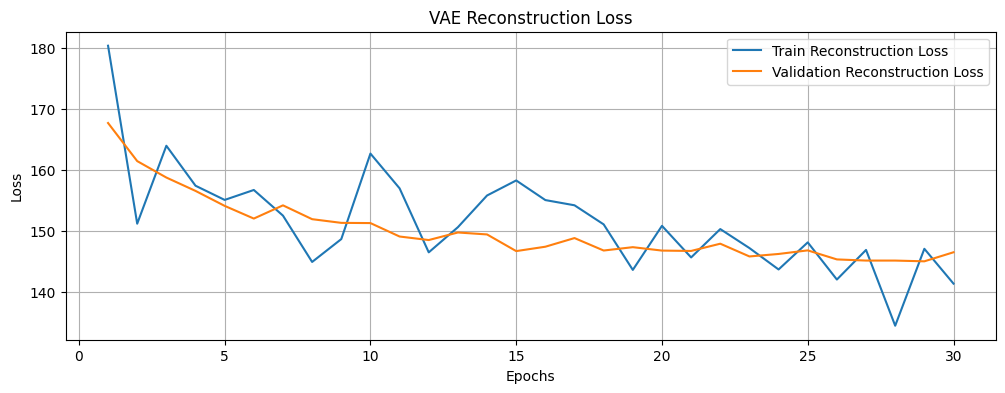

In [ ]:

import matplotlib.pyplot as plt

# Extract history
loss = history.history['loss']
reconstruction_loss = history.history['reconstruction_loss']
kl_loss = history.history['kl_loss']

# Optional: if you have validation metrics
val_loss = history.history.get('val_loss')
val_reconstruction = history.history.get('val_reconstruction_loss')
val_kl = history.history.get('val_kl_loss')

epochs = range(1, len(loss) + 1)

# Plot total loss
plt.figure(figsize=(12, 4))
plt.plot(epochs, loss, label='Train Total Loss')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Total Loss')
plt.title('VAE Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot reconstruction loss
plt.figure(figsize=(12, 4))
plt.plot(epochs, reconstruction_loss, label='Train Reconstruction Loss')
if val_reconstruction:
    plt.plot(epochs, val_reconstruction, label='Validation Reconstruction Loss')
plt.title('VAE Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

